In [1]:
from lerf.lerf import LERFModelConfig
from lerf.lerf_field import LERFField
import tinycudann as tcnn
import torch

/home/robot-lab/anaconda3/envs/lerf/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/robot-lab/anaconda3/envs/lerf/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/robot-lab/anaconda3/envs/lerf/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/robot-lab/anaconda3/envs/lerf/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
2023-08-08 13:56:13.219019: W tensorflow/stream_execut

In [3]:
config = LERFModelConfig()
config.hashgrid_layers, config.hashgrid_sizes, config.hashgrid_resolutions

weights = torch.load('outputs/CDSLablerf/lerf/2023-08-08_122309/nerfstudio_models//step-000029999.ckpt')
#weights = torch.load('outputs/CDSLablerf/lerf-lite/2023-07-28_212438/nerfstudio_models/step-000029999.ckpt')
field_weight = {}
for weight in weights['pipeline']:
    if "lerf" in weight:
        print(weight[len('_model.lerf_field.'):])
        field_weight[weight[len('_model.lerf_field.'):]] = weights['pipeline'][weight]

clip_encs.0.params
clip_encs.1.params
clip_net.params
dino_net.params


In [4]:
model = LERFField(config.hashgrid_layers, config.hashgrid_sizes, config.hashgrid_resolutions, 512)
model.load_state_dict(field_weight)

<All keys matched successfully>

In [5]:
class LerfNavigate(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, points, scale = 0.5):
        hashgrid = torch.concat([e(points) for e in self.model.clip_encs], dim = -1)
        return self.model.clip_net(torch.cat([hashgrid, torch.tensor([[scale]] * points.shape[0]).cuda()], dim = -1))

In [6]:
lerf_field = LerfNavigate(model)

In [7]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
cloud = o3d.io.read_point_cloud('/data/peiqi/clip-fields/demo/visualized_pointcloud/nyu_lab.ply')

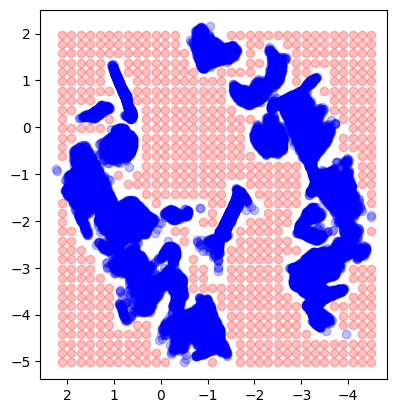

Found some valid points: (650, 2)


In [9]:
import numpy as np
from matplotlib import pyplot as plt

coordinates = np.array(cloud.points)
ys = coordinates[:, 1]
coordinates = coordinates[np.all([[ys < -0.2], [ys > -0.8]], axis = 0)[0]]
xs = coordinates[:, 0]
ys = coordinates[:, 1]
zs = coordinates[:, 2]
x_max = xs.max()
x_min = xs.min()
z_max = zs.max()
z_min = zs.min()
y_max = ys.max()
y_min = ys.min()

# This is the cutoff used for NYU kitchen
CUTOFF = 0.2

# Make a top down map for visualization. This step works best if the data is axis aligned.
def get_and_show_valid_points(coordinates, cutoff=CUTOFF, library=True):
    blockers = np.array([xs, zs]).T
    all_grid_points = np.array(np.meshgrid(np.arange(xs.min(), xs.max(), 0.2), np.arange(zs.min(), zs.max(), 0.2))).reshape(2, -1).T
    distance = np.linalg.norm(blockers[None, :, :] - all_grid_points[:, None, :], axis=2, ord=2)

    valid_points_index = distance.min(axis=1) > cutoff
    valid_points = all_grid_points[valid_points_index]

    ax = plt.subplot(111)
    ax.scatter(xs, zs, c="blue", alpha=0.25)
    ax.scatter(valid_points[:, 0], valid_points[:, 1], c="red", alpha = 0.25)
    ax.invert_xaxis()
    ax.set_aspect('equal', 'box')
    plt.show()
    return valid_points

valid_points = get_and_show_valid_points(coordinates)
print("Found some valid points:", valid_points.shape)

In [11]:
import pandas as pd
import open_clip

clip_model, _, _ = open_clip.create_model_and_transforms(
            "ViT-B-32",
            pretrained="laion2b_s34b_b79k",
        )

tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [12]:
eval_data = pd.read_csv('/data/peiqi/clip-fields/lab.csv')
queries = list(eval_data['query'])

xs, ys, zs, affords = list(eval_data['x']), list(eval_data['y']), list(eval_data['z']), list(eval_data['affordance'])
xyzs = torch.stack([torch.tensor(xs), torch.tensor(ys), torch.tensor(zs)], dim = 1)

In [13]:
import torch.nn.functional as F
all_clip_queries = tokenizer(queries)
print(queries, all_clip_queries)
with torch.no_grad():
    all_clip_tokens = clip_model.encode_text(all_clip_queries).float().to(DEVICE)
    all_clip_tokens = F.normalize(all_clip_tokens, p=2, dim=-1)

['Bottle on the ground', 'A laptop with no one sitting in front of it', 'Whiteboard', 'Baseball', 'Bowls without anyone sitting in front of it', 'Table Tennis pad', 'White robot arm', 'Gray school bag on the back of the chair', 'Purple bottle', 'A white lambda machine on the table', 'A man in the white shirt', 'A man in the gray', 'VR glasses', 'Tapes on the ground', 'Robot dog', 'The scoot', 'VR glasses package boxes on the ground', 'Tapes on the ground', "Let's play ping pong", 'Clean the whiteboard', 'Remove tapes on the ground', 'Turn on that robot dog', 'Ride the scoot and run away', 'Destroy that white machine on the table', 'Throw away purple boxes on the ground'] tensor([[49406,  5392,   525,  ...,     0,     0,     0],
        [49406,   320, 10464,  ...,     0,     0,     0],
        [49406, 40839, 49407,  ...,     0,     0,     0],
        ...,
        [49406,  2994,   518,  ...,     0,     0,     0],
        [49406, 11930,   682,  ...,     0,     0,     0],
        [49406,  

In [47]:
import tqdm
point_opacity = []
all_grid_points = np.array(np.meshgrid(np.arange(x_min, x_max, 0.2), np.arange(y_min, y_max, 0.2), np.arange(z_min, z_max, 0.2))).reshape(3, -1).T
with torch.no_grad():
    for data in tqdm.tqdm(all_grid_points, total=len(all_grid_points)):
        data = torch.tensor(data).unsqueeze(0)
        alignment = torch.zeros(1, 25).cuda()
        for scale in [1]:
            predicted_image_latents = lerf_field(data.to(DEVICE), scale)
            data_visual_tokens = F.normalize(predicted_image_latents, p=2, dim=-1).to(DEVICE)
            alignment = torch.max(alignment, (data_visual_tokens.float() @ all_clip_tokens.float().T))
        point_opacity.append(alignment)

point_opacity = torch.cat(point_opacity).T

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3672/3672 [00:04<00:00, 831.59it/s]


In [48]:
max_points = []
max_points_goto = []
mean_points = []
mean_point_goto = []
use_threshold = True
for query, q in zip(queries, point_opacity ):
    alpha = q.detach().cpu().numpy()
    pts = torch.tensor(cloud.points)

    # We are thresholding the points to get the top 0.01% of points.
    # Subsample if the number of points is too large.
    threshold = torch.quantile(q[::10, ...], 0.9999).cpu().item()

    # Normalize alpha
    a_norm = (alpha - alpha.min()) / (alpha.max() - alpha.min())
    a_norm = torch.as_tensor(a_norm[..., np.newaxis])
    max_point = pts[torch.argmax(a_norm)]
    max_points.append(max_point)
    print(f"LOOKAT {query} {max_point.tolist()}")

LOOKAT Bottle on the ground [-0.22050963, -0.4479313, -3.332489]
LOOKAT A laptop with no one sitting in front of it [-1.3972666, -0.9326437, -2.1160512]
LOOKAT Whiteboard [-1.0897584, -0.8753954, -2.4180713]
LOOKAT Baseball [-1.1576333, 0.34076867, -1.6282204]
LOOKAT Bowls without anyone sitting in front of it [-0.31623754, -0.28490502, -3.2250082]
LOOKAT Table Tennis pad [-1.642389, -0.6647047, -1.6489487]
LOOKAT White robot arm [-0.38958752, -0.6935748, -3.5230825]
LOOKAT Gray school bag on the back of the chair [-1.0134279, -0.80742985, -3.8372731]
LOOKAT Purple bottle [-0.0017096637, -0.69654983, -3.3069105]
LOOKAT A white lambda machine on the table [-0.36708426, -0.75322706, -3.577146]
LOOKAT A man in the white shirt [-0.34569147, -0.8674781, -3.368155]
LOOKAT A man in the gray [-0.056410167, 0.14130601, -3.3725042]
LOOKAT VR glasses [-1.6301824, 0.6267114, -1.6902936]
LOOKAT Tapes on the ground [-1.482567, 0.5668345, -1.9633739]
LOOKAT Robot dog [-3.4392326, -1.050569, -2.594645

In [49]:
correctness = torch.linalg.norm((torch.stack(max_points)[:, [0, 2]] - xyzs[:, [0, 2]]), dim = -1) <= torch.tensor(affords)
np.array(queries)[torch.where(correctness)[0].numpy()], np.array(queries)[torch.where(~correctness)[0].numpy()], len(np.array(queries)[torch.where(correctness)[0].numpy()]) / len(correctness)

(array(['Bottle on the ground', 'Whiteboard', 'White robot arm',
        'A man in the gray', 'Clean the whiteboard'], dtype='<U43'),
 array(['A laptop with no one sitting in front of it', 'Baseball',
        'Bowls without anyone sitting in front of it', 'Table Tennis pad',
        'Gray school bag on the back of the chair', 'Purple bottle',
        'A white lambda machine on the table', 'A man in the white shirt',
        'VR glasses', 'Tapes on the ground', 'Robot dog', 'The scoot',
        'VR glasses package boxes on the ground', 'Tapes on the ground',
        "Let's play ping pong", 'Remove tapes on the ground',
        'Turn on that robot dog', 'Ride the scoot and run away',
        'Destroy that white machine on the table',
        'Throw away purple boxes on the ground'], dtype='<U43'),
 0.2)

In [50]:
torch.linalg.norm((torch.stack(max_points)[:, [0, 2]] - xyzs[:, [0, 2]]), dim = -1)

tensor([0.4818, 2.3947, 0.6819, 2.6784, 3.1093, 2.8052, 0.9265, 2.1683, 4.6258,
        3.8518, 4.4077, 0.2955, 2.3168, 1.9327, 4.7423, 3.8057, 2.5390, 1.9327,
        0.5715, 0.5983, 2.9959, 3.7889, 3.8057, 2.1696, 2.5390],
       dtype=torch.float64)

In [35]:
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib.cm as cm


def set_proper_aspect_ratio(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

def plot_with_matplotlib(cloud, 
            **kwargs):

    colors = np.array(cloud.colors) * 255

    #ptp = cloud.points.ptp()

    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.view_init(elev=kwargs.get("elev", 0.0), azim=kwargs.get("azim", 90.0))
    
    points = np.array(cloud.points)

    ax.scatter(
        points[:, 0],
        points[:, 1],
        points[:, 2],
        marker="D",
        facecolors=colors / 255,
        alpha=0.25,
        zdir="z",
        depthshade=True,
        s=kwargs["initial_point_size"] or 7.956951856613159 / 10
    )


    if "text" in kwargs:
        for i, (points, text) in enumerate(kwargs["text"]):
            ax.text(points[0], points[1], points[2], text)

    if "title" in kwargs:
        ax.set_title(kwargs["title"])
    #plt.plot([waypoint[0] for waypoint in waypoints], [0 for waypoint in waypoints],  [waypoint[1] for waypoint in waypoints], c='r')
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    set_proper_aspect_ratio(ax)

    return plt.show()

/tmp/ipykernel_658235/3745696891.py:16: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  text=zip(np.array(max_points)[[1, 9, 11]], np.array(queries)[[1, 9, 11]]),
/tmp/ipykernel_658235/3745696891.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text=zip(np.array(max_points)[[1, 9, 11]], np.array(queries)[[1, 9, 11]]),


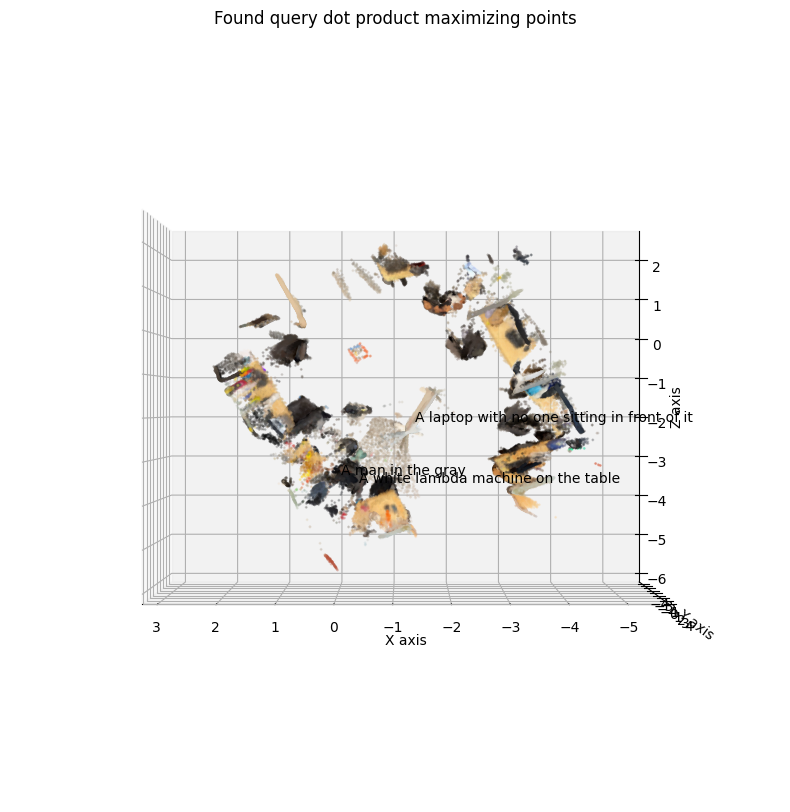

In [38]:
plot_with_matplotlib(
    cloud,
    width=800,
    height=500,
    background="black",
    mesh=False,
    use_as_color=["red", "green", "blue"],
    initial_point_size=None,
    cmap="hsv",
    polylines=None,
    linewidth=5,
    return_scene=False,
    output_name="pyntcloud_plot",
    elev=0.,
    azim=90.,
    text=zip(np.array(max_points)[[1, 9, 11]], np.array(queries)[[1, 9, 11]]),
    title="Found query dot product maximizing points",
    goto=max_points_goto,
)